In [1]:
import numpy as np
from PIL import Image, ImageFont, ImageDraw
from fontTools.ttLib import TTFont
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.feature import hog
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import os

def extract_font_glyphs(font_path):
    font = TTFont(font_path)
    cmap = font['cmap'].getcmap(3, 1).cmap
    glyphs = {}
    for char, glyph_id in cmap.items():
        if chr(char).isalnum() or chr(char).isspace():
            glyphs[chr(char)] = glyph_id
    return glyphs

def render_glyph(font_path, glyph, size=(50, 50)):
    font = ImageFont.truetype(font_path, size=40)
    img = Image.new('L', size, color=255)
    draw = ImageDraw.Draw(img)
    if glyph != ' ':  # Don't render space as it will be empty
        draw.text((5, 5), glyph, font=font, fill=0)
    return np.array(img)

def segment_characters(image):
    threshold = threshold_otsu(image)
    binary = image < threshold
    labeled = label(binary)
    regions = regionprops(labeled)
    return [region.bbox for region in regions if region.area > 50]

def extract_features(image):
    # Normalize the image
    image = (image - image.min()) / (image.max() - image.min() + 1e-8)
    # Extract HOG features
    features, _ = hog(image, orientations=8, pixels_per_cell=(4, 4),
                      cells_per_block=(1, 1), visualize=True)
    return features

def compare_images(img1, img2):
    img1 = resize(img1, img2.shape, anti_aliasing=True, mode='constant')
    img1 = (img1 - img1.min()) / (img1.max() - img1.min() + 1e-8)
    img2 = (img2 - img2.min()) / (img2.max() - img2.min() + 1e-8)
    
    ssim_score = ssim(img1, img2, data_range=1.0)
    
    hog1 = extract_features(img1)
    hog2 = extract_features(img2)
    hog_similarity = 1 - cosine(hog1, hog2)
    
    return 0.5 * ssim_score + 0.5 * hog_similarity

def identify_character(char_image, reference_glyphs):
    best_match = None
    best_similarity = -1
    similarities = {}
    for char, glyph_image in reference_glyphs.items():
        if char == ' ':  # Skip comparing with space
            continue
        resized_char_image = resize(char_image, glyph_image.shape, anti_aliasing=True, mode='constant')
        similarity = compare_images(resized_char_image, glyph_image)
        similarities[char] = similarity
        if similarity > best_similarity:
            best_similarity = similarity
            best_match = char
    return best_match, best_similarity, similarities

def translate_image(image_path, font_path):
    debug_folder = "debug_output"
    os.makedirs(debug_folder, exist_ok=True)

    glyphs = extract_font_glyphs(font_path)
    reference_glyphs = {char: render_glyph(font_path, char) for char in glyphs}

    # Debug: Save all reference glyphs
    for char, glyph_image in reference_glyphs.items():
        plt.figure(figsize=(5, 5))
        plt.imshow(glyph_image, cmap='gray')
        plt.title(f"Reference Glyph: '{char}' (ASCII: {ord(char)})")
        plt.savefig(os.path.join(debug_folder, f"ref_glyph_{ord(char)}.png"))
        plt.close()

    image = np.array(Image.open(image_path).convert('L'))
    char_regions = segment_characters(image)

    translated_text = ""
    for i, bbox in enumerate(char_regions):
        minr, minc, maxr, maxc = bbox
        char_image = image[minr:maxr, minc:maxc]
        identified_char, similarity, all_similarities = identify_character(char_image, reference_glyphs)
        translated_text += identified_char if identified_char else '?'

        resized_char_image = resize(char_image, reference_glyphs[identified_char].shape, anti_aliasing=True, mode='constant')

        plt.figure(figsize=(25, 5))
        plt.subplot(151)
        plt.imshow(char_image, cmap='gray')
        plt.title(f"Segmented Character {i}")
        plt.subplot(152)
        plt.imshow(resized_char_image, cmap='gray')
        plt.title("Resized Segmented Character")
        plt.subplot(153)
        plt.imshow(reference_glyphs[identified_char], cmap='gray')
        plt.title(f"Best Match: '{identified_char}' (ASCII: {ord(identified_char)})\nSimilarity: {similarity:.2f}")
        plt.subplot(154)
        plt.bar(range(len(all_similarities)), list(all_similarities.values()), tick_label=list(all_similarities.keys()))
        plt.title("Similarity Scores")
        plt.xticks(rotation=90)
        plt.subplot(155)
        plt.imshow(canny(resized_char_image), cmap='gray')
        plt.title("Edge Detection")
        plt.tight_layout()
        plt.savefig(os.path.join(debug_folder, f"debug_char_{i}.png"))
        plt.close()

    return translated_text

# Usage
font_path = 'codes/CRYPTOGRAM CODEX/CRYPTOGRAM CODEX 2/CipherFontA.ttf'
image_path = 'code.png'

translated_text = translate_image(image_path, font_path)
print(f"Translated text: {translated_text}")

KeyboardInterrupt: 

Starting character segmentation...
Loading image...
Image loaded. Shape: (1670, 1922)
Thresholding image...
Labeling connected components...
Finding regions...
Found 13748 regions
Filtered to 2248 character regions
Character segmentation complete.
Starting character labeling...
Displaying characters 0 to 99


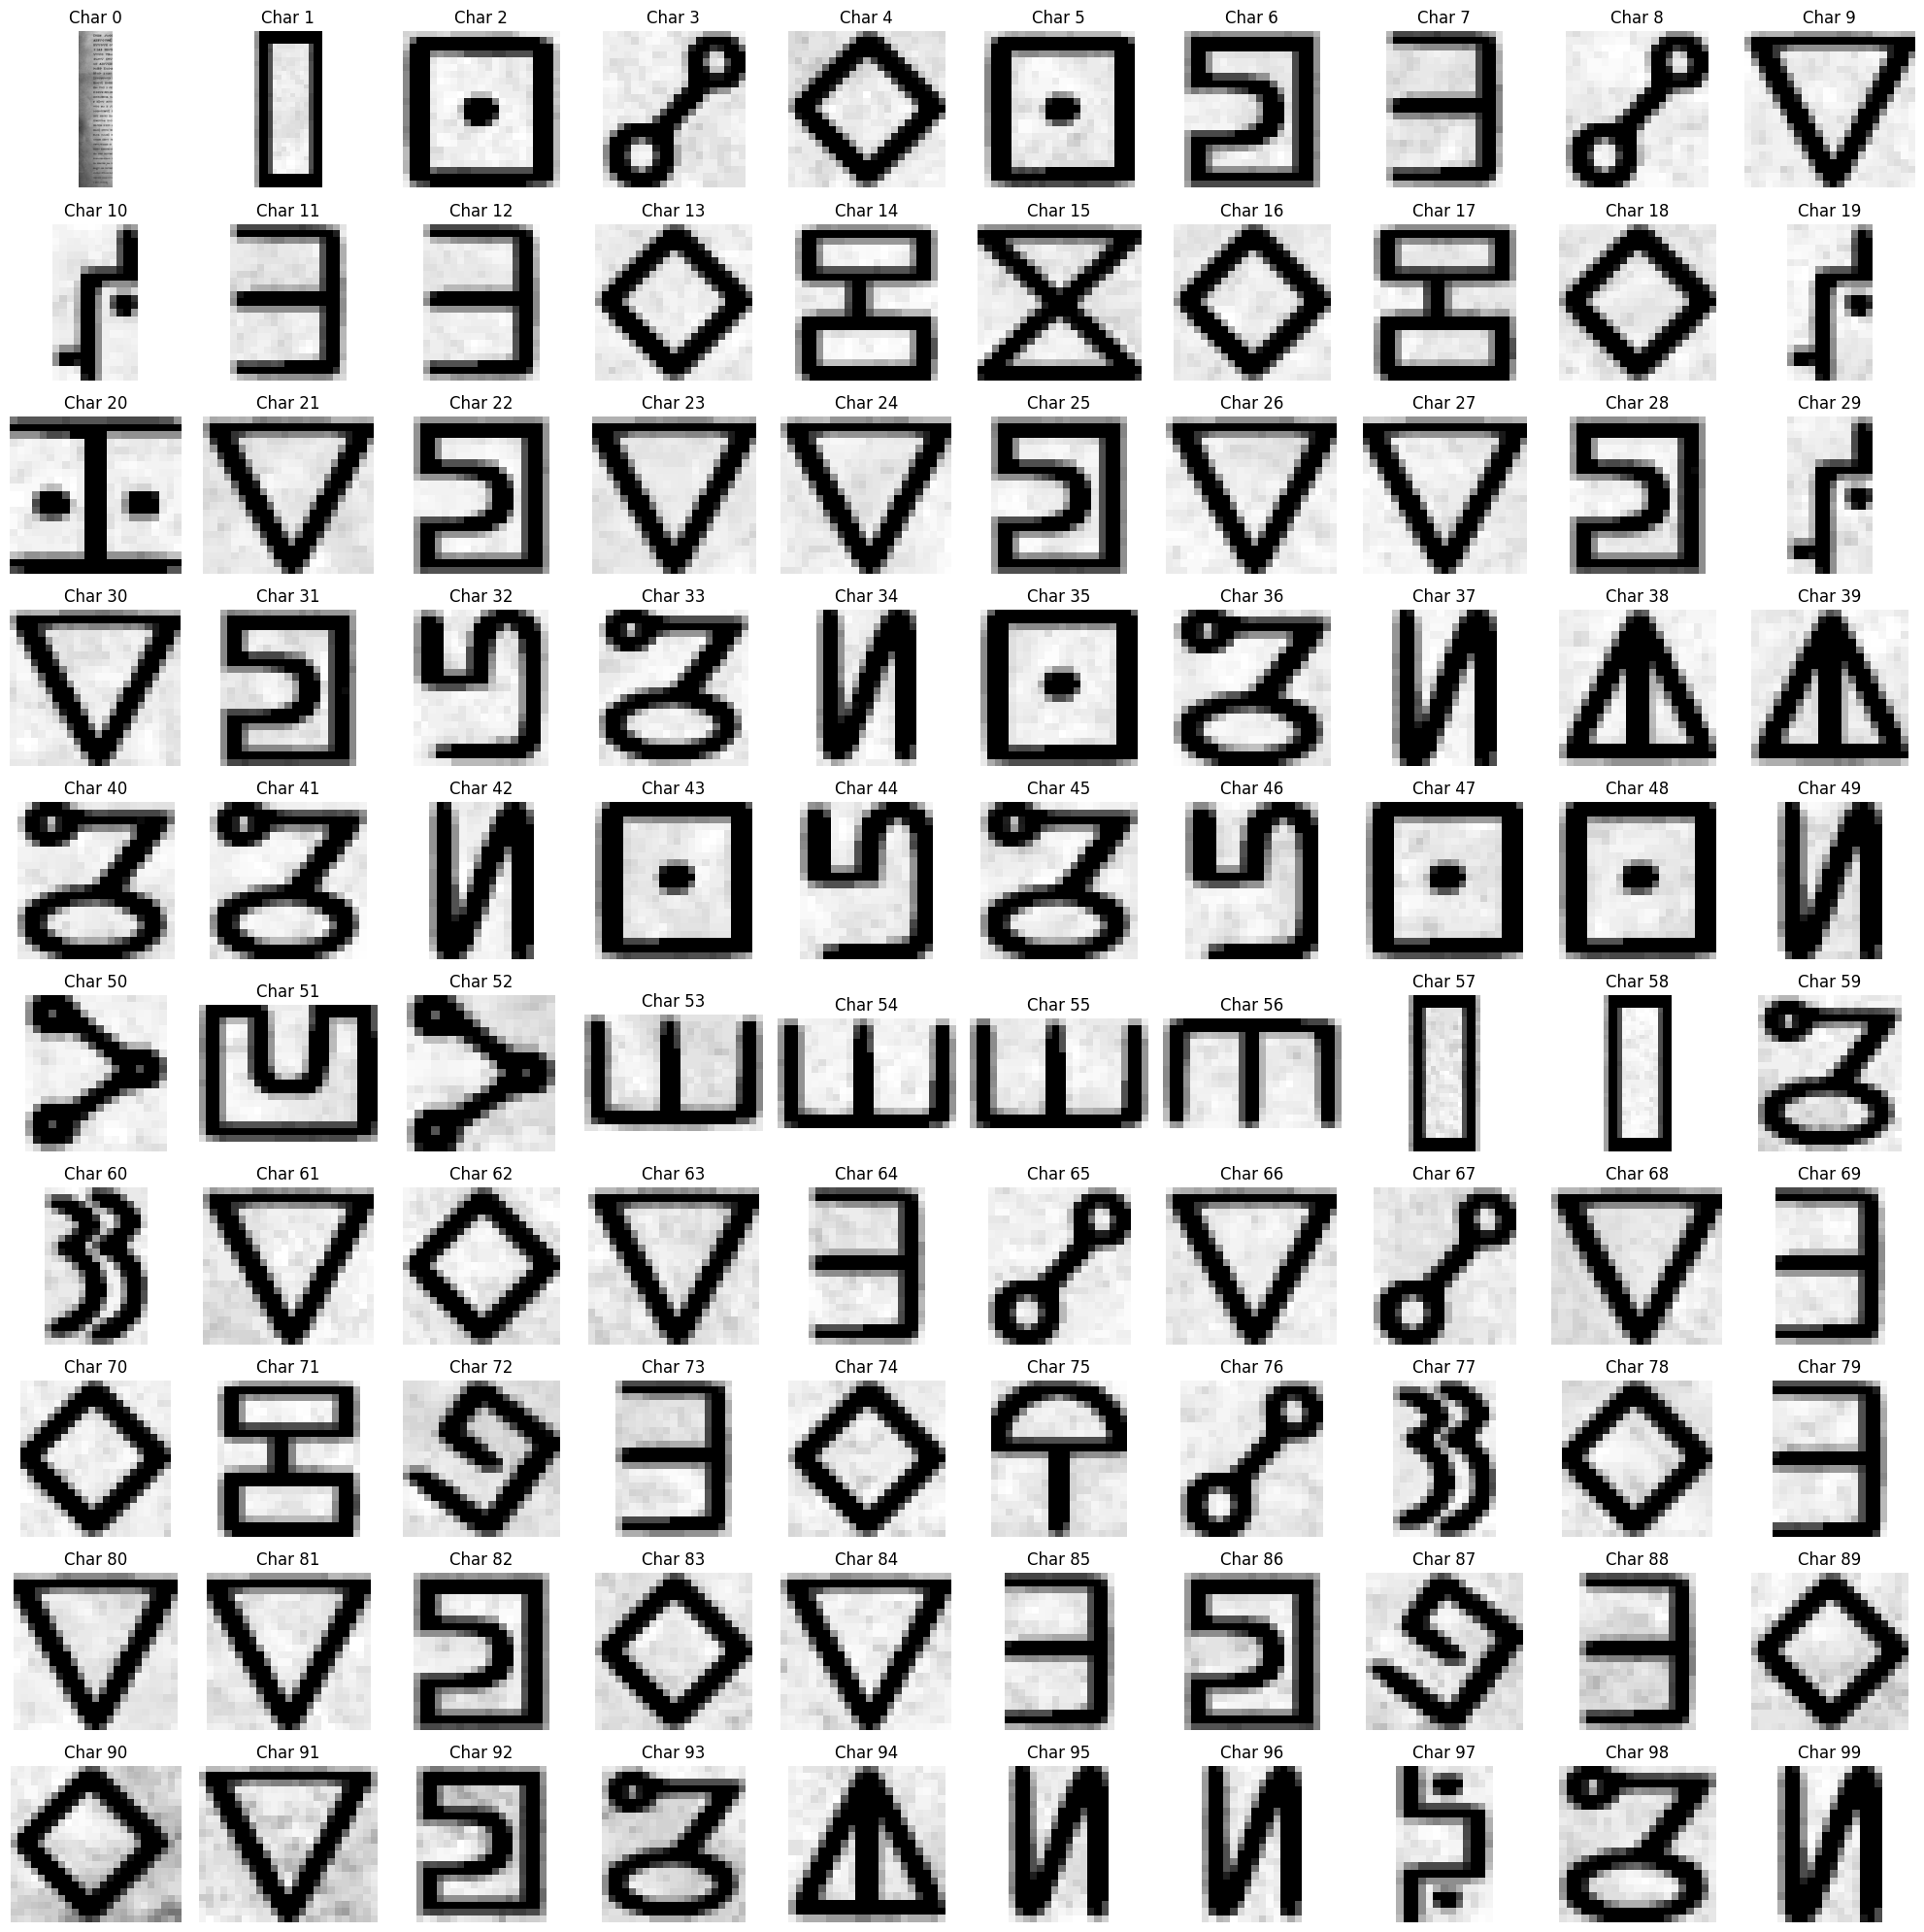

Character labeling complete.
Saving labeled data...
Labeled data saved to labeled_characters


In [1]:
import numpy as np
from PIL import Image
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
import json
import math

def segment_characters(image_path):
    print("Loading image...")
    image = np.array(Image.open(image_path).convert('L'))
    print("Image loaded. Shape:", image.shape)
    
    print("Thresholding image...")
    threshold = threshold_otsu(image)
    binary = image < threshold
    
    print("Labeling connected components...")
    labeled = label(binary)
    
    print("Finding regions...")
    regions = regionprops(labeled)
    print(f"Found {len(regions)} regions")
    
    char_regions = [region.bbox for region in regions if region.area > 50]
    print(f"Filtered to {len(char_regions)} character regions")
    
    return image, char_regions

def display_characters_page(image, char_regions, page, chars_per_page=100):
    start_index = page * chars_per_page
    end_index = min(start_index + chars_per_page, len(char_regions))
    n_chars = end_index - start_index
    n_cols = min(10, n_chars)
    n_rows = math.ceil(n_chars / n_cols)
    
    print(f"Displaying characters {start_index} to {end_index - 1}")
    
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
    axs = axs.flatten() if n_rows > 1 else [axs]
    
    for i, ax in enumerate(axs):
        if i < n_chars:
            bbox = char_regions[start_index + i]
            minr, minc, maxr, maxc = bbox
            char_image = image[minr:maxr, minc:maxc]
            ax.imshow(char_image, cmap='gray')
            ax.set_title(f"Char {start_index + i}")
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def label_characters(image, char_regions):
    labels = {}
    total_chars = len(char_regions)
    chars_per_page = 100
    total_pages = math.ceil(total_chars / chars_per_page)
    
    display_option = input("Do you want to display characters? (y/n): ")
    if display_option.lower() == 'y':
        for page in range(total_pages):
            display_characters_page(image, char_regions, page, chars_per_page)
            
            start_index = page * chars_per_page
            end_index = min(start_index + chars_per_page, total_chars)
            
            for i in range(start_index, end_index):
                label = input(f"Enter label for character {i} (or 'skip' to skip, 'quit' to finish): ")
                if label.lower() == 'quit':
                    return labels
                if label.lower() != 'skip':
                    labels[i] = label
            
            if page < total_pages - 1:
                continue_labeling = input("Continue to next page? (y/n): ")
                if continue_labeling.lower() != 'y':
                    break
    else:
        print("Skipping character display. Please provide labels based on your knowledge of the characters.")
        for i in range(total_chars):
            label = input(f"Enter label for character {i} (or 'skip' to skip, 'quit' to finish): ")
            if label.lower() == 'quit':
                break
            if label.lower() != 'skip':
                labels[i] = label
    
    return labels

def save_labeled_data(image, char_regions, labels, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for i, bbox in enumerate(char_regions):
        if i in labels:
            minr, minc, maxr, maxc = bbox
            char_image = image[minr:maxr, minc:maxc]
            char_image = resize(char_image, (50, 50), anti_aliasing=True)
            plt.imsave(os.path.join(output_dir, f"{labels[i]}_{i}.png"), char_image, cmap='gray')
    
    with open(os.path.join(output_dir, 'labels.json'), 'w') as f:
        json.dump(labels, f)

def main():
    image_path = 'code.png'  # Replace with your image path
    output_dir = 'labeled_characters'
    
    try:
        print("Starting character segmentation...")
        image, char_regions = segment_characters(image_path)
        print("Character segmentation complete.")
        
        print("Starting character labeling...")
        labels = label_characters(image, char_regions)
        print("Character labeling complete.")
        
        print("Saving labeled data...")
        save_labeled_data(image, char_regions, labels, output_dir)
        print(f"Labeled data saved to {output_dir}")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

if __name__ == "__main__":
    main()

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.0734 - loss: 3.0393 - val_accuracy: 0.1500 - val_loss: 2.9889
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1178 - loss: 2.9529 - val_accuracy: 0.2500 - val_loss: 2.8996
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1441 - loss: 2.8353 - val_accuracy: 0.2500 - val_loss: 2.8164
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2290 - loss: 2.6696 - val_accuracy: 0.4000 - val_loss: 2.6465
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2866 - loss: 2.5399 - val_accuracy: 0.4500 - val_loss: 2.5028
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3769 - loss: 2.1990 - val_accuracy: 0.5000 - val_loss: 2.2886
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4778 - loss: 1.9960 - val_accuracy: 0.6500 - val_loss: 2.1335
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5863 - loss: 1.8138 - val_accuracy: 0.6500 - val_loss: 2.0590


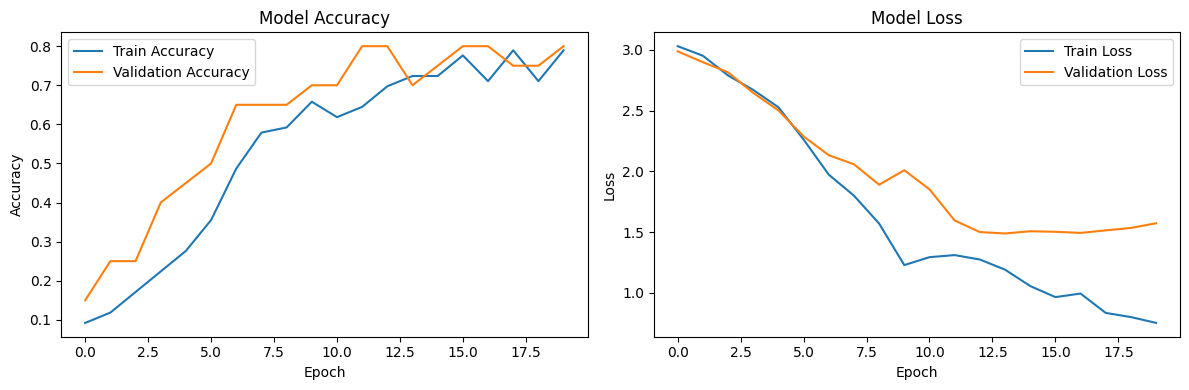

Model trained and saved. You can now use it for character recognition.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import json
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

def load_labeled_data(data_dir):
    images = []
    labels = []
    with open(os.path.join(data_dir, 'labels.json'), 'r') as f:
        label_dict = json.load(f)
    
    for filename in os.listdir(data_dir):
        if filename.endswith('.png'):
            img = np.array(Image.open(os.path.join(data_dir, filename)).convert('L'))
            images.append(img)
            label = filename.split('_')[0]
            labels.append(label)
    
    return np.array(images), np.array(labels)

def prepare_data(images, labels):
    # Normalize images
    images = images.astype('float32') / 255.0
    images = np.expand_dims(images, axis=-1)  # Add channel dimension
    
    # Encode labels
    unique_labels = np.unique(labels)
    label_to_index = {label: index for index, label in enumerate(unique_labels)}
    index_to_label = {index: label for label, index in label_to_index.items()}
    encoded_labels = np.array([label_to_index[label] for label in labels])
    
    return images, to_categorical(encoded_labels), label_to_index, index_to_label

def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, X_val, y_val):
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))
    return history

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def recognize_characters(model, image_path, label_to_index, index_to_label):
    # Implement character segmentation (you can reuse the code from the labeling script)
    # For each segmented character:
    #   1. Preprocess the character image (resize, normalize)
    #   2. Use model.predict() to get the prediction
    #   3. Convert the prediction to the corresponding label
    # Return the full translated text
    pass  # Implement this function based on your specific needs

def main():
    data_dir = 'labeled_characters'
    
    # Load and prepare data
    images, labels = load_labeled_data(data_dir)
    images, encoded_labels, label_to_index, index_to_label = prepare_data(images, labels)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)
    
    # Create and train model
    model = create_model(input_shape=X_train.shape[1:], num_classes=len(label_to_index))
    history = train_model(model, X_train, y_train, X_val, y_val)
    
    # Plot training history
    plot_training_history(history)
    
    # Save the model
    model.save('cipher_recognition_model.h5')
    
    print("Model trained and saved. You can now use it for character recognition.")

if __name__ == "__main__":
    main()

Label mapping:
  0: D
  1: D
  2: T
  3: C
  4: N
  5: T
  6: R
  7: A
  8: C
  9: E
  10: G
  11: A
  12: A
  13: N
  14: D
  15: B
  16: N
  17: D
  18: N
  19: G
  20: V
  21: E
  22: R
  23: E
  24: E
  25: R
  26: G
  27: E
  28: R
  29: G
  30: E
  31: R
  32: H
  33: I
  34: S
  35: L
  36: L
  37: I
  38: I
  39: L
  40: I
  41: I
  42: S
  43: T
  44: H
  45: I
  46: H
  47: T
  48: T
  49: S
  50: U
  51: Y
  52: U
  53: O
  54: O
  55: O
  56: V
  59: I
  60: K
  61: E
  62: N
  63: E
  64: A
  65: C
  66: E
  67: C
  68: E
  69: A
  70: E
  71: D
  72: M
  73: A
  74: N
  75: P
  76: C
  77: K
  78: N
  79: A
  80: E
  81: E
  82: R
  83: N
  84: E
  85: A
  86: R
  87: M
  88: N
  89: E
  90: R
  91: I
  92: L
  93: S
  94: S
  95: S
  96: S
  97: F
  98: I
  99: S
Number of segmented characters: 1044


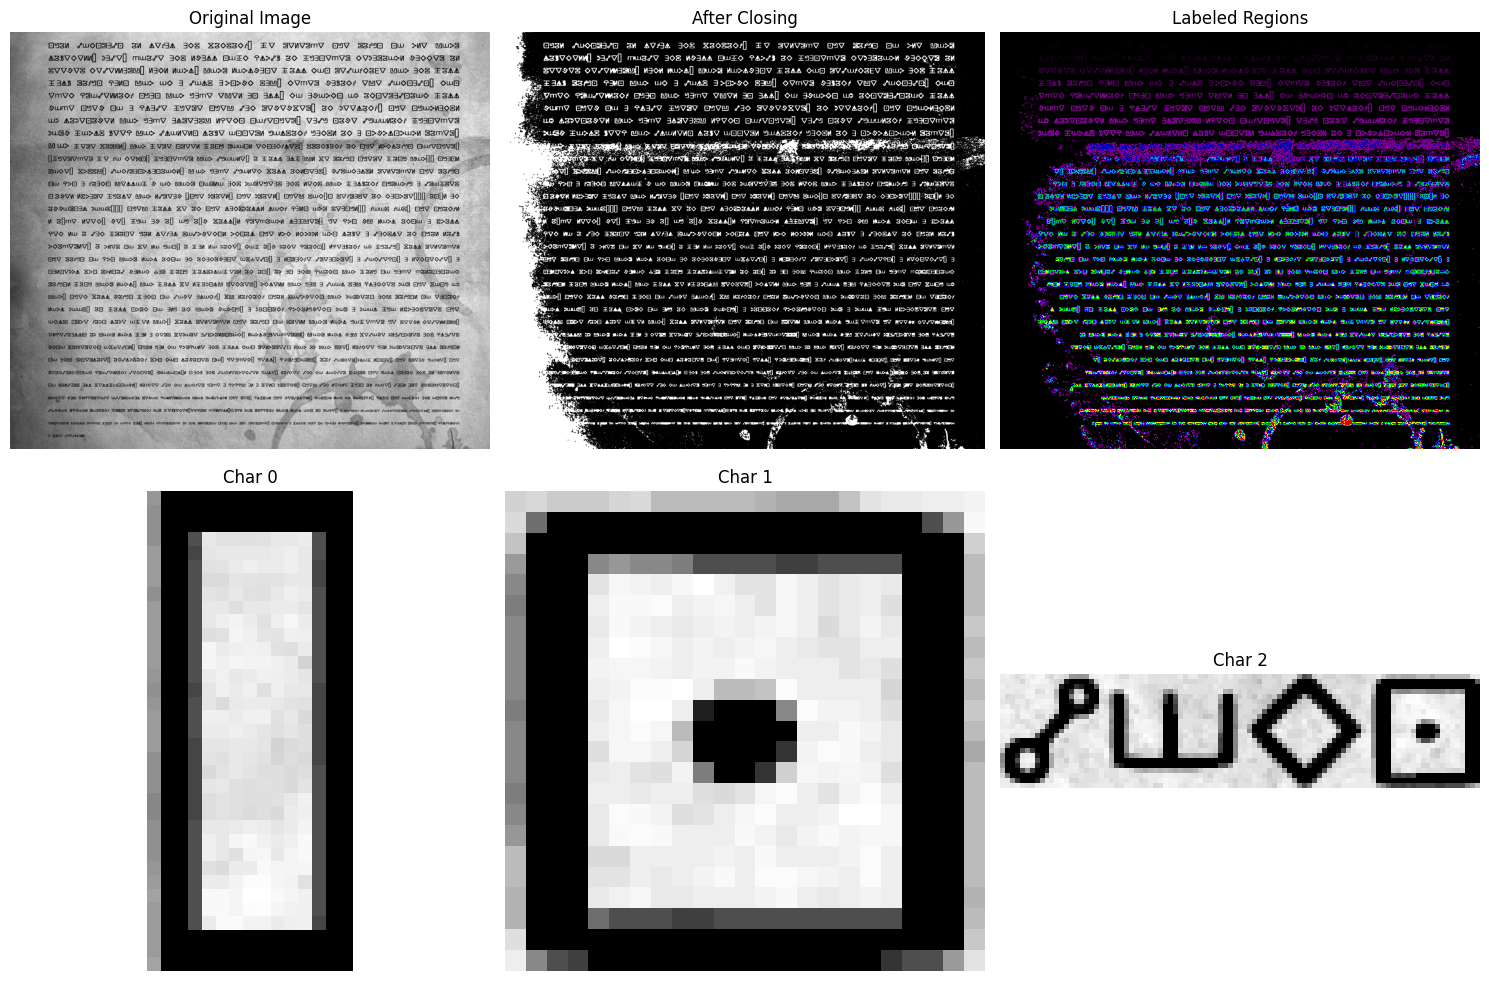

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Character 0:
  Predicted label: C
  Prediction confidence: 0.2895
  Top 3 predictions: [('C', 0.2895151), ('N', 0.13173942), ('G', 0.116439454)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Character 1:
  Predicted label: C
  Prediction confidence: 0.2906
  Top 3 predictions: [('C', 0.29056957), ('N', 0.13185172), ('G', 0.116524115)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Character 2:
  Predicted label: C
  Prediction confidence: 0.2900
  Top 3 predictions: [('C', 0.29004744), ('N', 0.13205796), ('G', 0.11644152)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Character 3:
  Predicted label: C
  Prediction confidence: 0.2903
  Top 3 predictions: [('C', 0.29030117), ('N', 0.13186127), ('G', 0.11647631)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Character 4:
  Predicted label: C
  Prediction confidence: 0.2900
  Top 3 predictions: [('C', 0.29003477), ('N', 0.13184136), ('G', 0.11651588)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━

KeyboardInterrupt: 

In [6]:
import numpy as np
from PIL import Image
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.transform import resize
import tensorflow as tf
import json
import os
import matplotlib.pyplot as plt

def load_model_and_labels(model_path, labels_path):
    model = tf.keras.models.load_model(model_path)
    
    with open(labels_path, 'r') as f:
        label_dict = json.load(f)
    
    index_to_label = {int(k): v for k, v in label_dict.items()}
    label_to_index = {v: int(k) for k, v in label_dict.items()}
    
    print("Label mapping:")
    for index, label in index_to_label.items():
        print(f"  {index}: {label}")
    
    return model, label_to_index, index_to_label

def segment_characters(image, min_area=100, max_area=1000):
    # Apply closing to connect nearby components
    closed = closing(image < threshold_otsu(image), square(3))
    
    labeled = label(closed)
    regions = regionprops(labeled)
    char_regions = [region.bbox for region in regions if min_area < region.area < max_area]
    
    print(f"Number of segmented characters: {len(char_regions)}")
    
    # Display first few segmented characters and the full image
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    axs[0, 0].imshow(image, cmap='gray')
    axs[0, 0].set_title("Original Image")
    axs[0, 0].axis('off')
    
    axs[0, 1].imshow(closed, cmap='gray')
    axs[0, 1].set_title("After Closing")
    axs[0, 1].axis('off')
    
    axs[0, 2].imshow(labeled, cmap='nipy_spectral')
    axs[0, 2].set_title("Labeled Regions")
    axs[0, 2].axis('off')
    
    for i, bbox in enumerate(char_regions[:3]):
        minr, minc, maxr, maxc = bbox
        char_image = image[minr:maxr, minc:maxc]
        axs[1, i].imshow(char_image, cmap='gray')
        axs[1, i].set_title(f"Char {i}")
        axs[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return char_regions

def preprocess_character(char_image, target_size=(50, 50)):
    resized = resize(char_image, target_size, anti_aliasing=True)
    normalized = resized.astype('float32') / 255.0
    return np.expand_dims(normalized, axis=-1)

def recognize_characters(model, image_path, label_to_index, index_to_label):
    image = np.array(Image.open(image_path).convert('L'))
    
    char_regions = segment_characters(image)
    char_regions.sort(key=lambda x: x[1])
    
    translated_text = ""
    for i, bbox in enumerate(char_regions):
        minr, minc, maxr, maxc = bbox
        char_image = image[minr:maxr, minc:maxc]
        
        processed_char = preprocess_character(char_image)
        prediction = model.predict(np.expand_dims(processed_char, axis=0))[0]
        predicted_index = np.argmax(prediction)
        predicted_label = index_to_label[predicted_index]
        
        translated_text += predicted_label
        
        if i < 5:  # Print details for first 5 characters
            print(f"Character {i}:")
            print(f"  Predicted label: {predicted_label}")
            print(f"  Prediction confidence: {prediction[predicted_index]:.4f}")
            print(f"  Top 3 predictions: {sorted(zip(index_to_label.values(), prediction), key=lambda x: x[1], reverse=True)[:3]}")
    
    return translated_text

def main():
    model_path = 'cipher_recognition_model.h5'
    labels_path = 'labeled_characters/labels.json'
    cipher_image_path = 'code.png'  # Replace with your new cipher image path
    
    model, label_to_index, index_to_label = load_model_and_labels(model_path, labels_path)
    
    translated_text = recognize_characters(model, cipher_image_path, label_to_index, index_to_label)
    
    print(f"\nTranslated text: {translated_text}")

if __name__ == "__main__":
    main()

Label mapping:
  0: D
  1: D
  2: T
  3: C
  4: N
  5: T
  6: R
  7: A
  8: C
  9: E
  10: G
  11: A
  12: A
  13: N
  14: D
  15: B
  16: N
  17: D
  18: N
  19: G
  20: V
  21: E
  22: R
  23: E
  24: E
  25: R
  26: G
  27: E
  28: R
  29: G
  30: E
  31: R
  32: H
  33: I
  34: S
  35: L
  36: L
  37: I
  38: I
  39: L
  40: I
  41: I
  42: S
  43: T
  44: H
  45: I
  46: H
  47: T
  48: T
  49: S
  50: U
  51: Y
  52: U
  53: O
  54: O
  55: O
  56: V
  59: I
  60: K
  61: E
  62: N
  63: E
  64: A
  65: C
  66: E
  67: C
  68: E
  69: A
  70: E
  71: D
  72: M
  73: A
  74: N
  75: P
  76: C
  77: K
  78: N
  79: A
  80: E
  81: E
  82: R
  83: N
  84: E
  85: A
  86: R
  87: M
  88: N
  89: E
  90: R
  91: I
  92: L
  93: S
  94: S
  95: S
  96: S
  97: F
  98: I
  99: S
Number of segmented characters: 1044


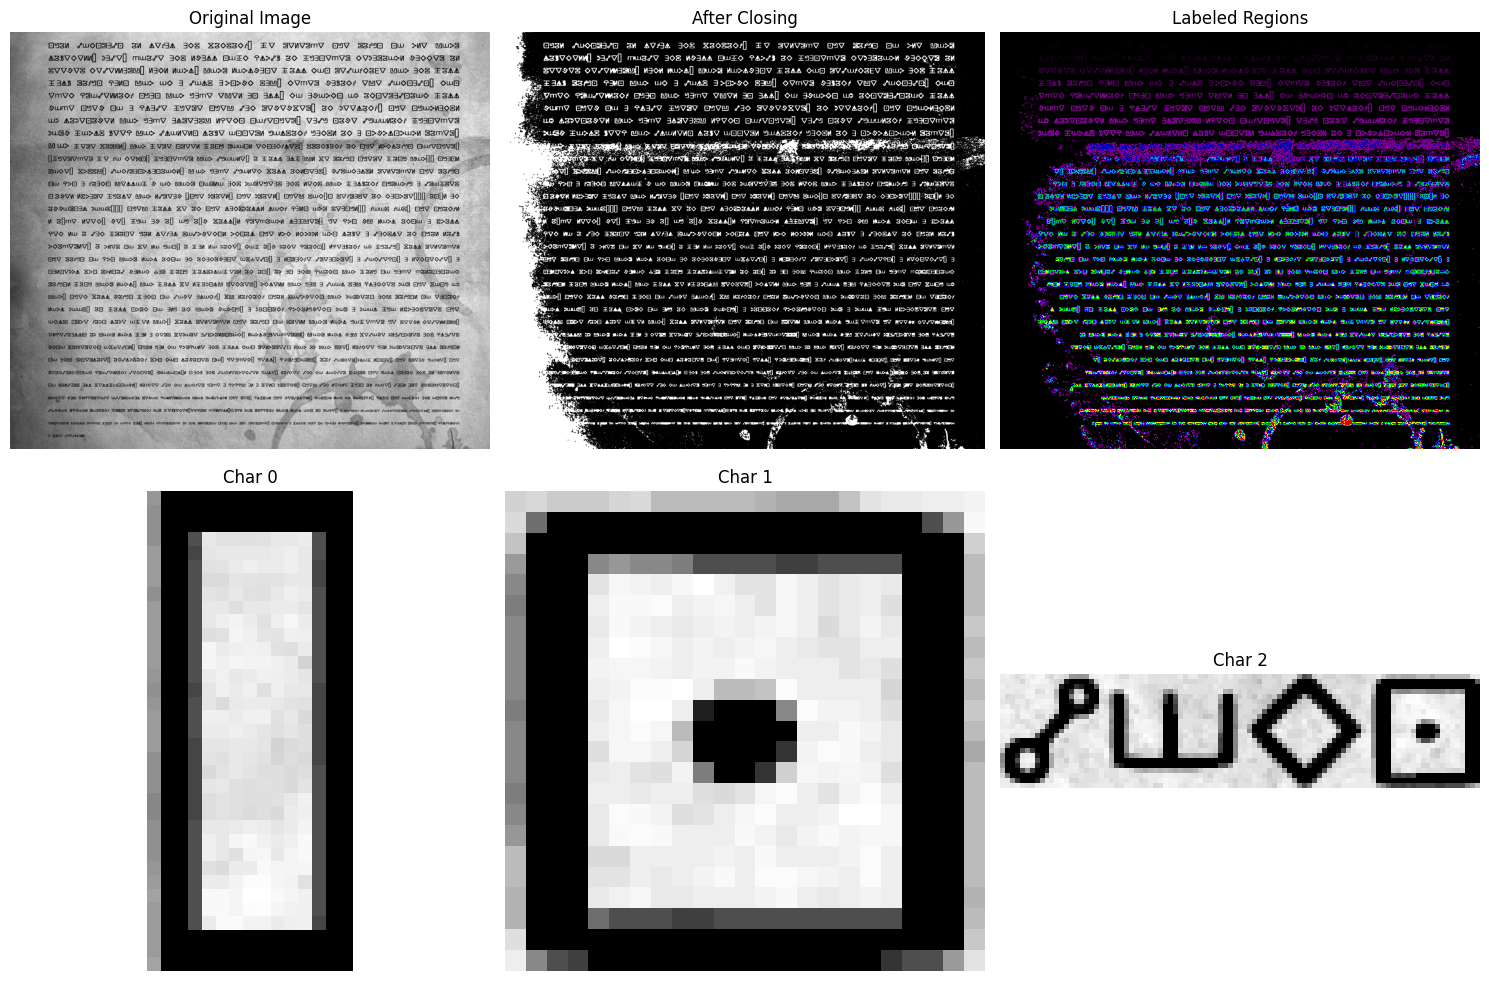

KeyError: Ellipsis

In [9]:
import numpy as np
from PIL import Image
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.transform import resize
from skimage.morphology import closing, square
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import json
import matplotlib.pyplot as plt

# ... [previous functions for segmentation and preprocessing remain the same] ...

def create_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def retrain_model(segmented_chars, labels, old_model, label_to_index):
    X = np.array([preprocess_character(char) for char in segmented_chars])
    y = np.array([label_to_index[label] for label in labels])
    y = to_categorical(y)

    new_model = create_model(X.shape[1:], len(label_to_index))
    new_model.set_weights(old_model.get_weights())  # Transfer weights from old model

    history = new_model.fit(X, y, epochs=10, validation_split=0.2, batch_size=32)
    
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    return new_model

def main():
    model_path = 'cipher_recognition_model.h5'
    labels_path = 'labeled_characters/labels.json'
    cipher_image_path = 'code.png'
    
    old_model, label_to_index, index_to_label = load_model_and_labels(model_path, labels_path)
    
    image = np.array(Image.open(cipher_image_path).convert('L'))
    char_regions = segment_characters(image)
    
    # Here, you would manually label a subset of the segmented characters
    # For demonstration, let's assume we've labeled the first 100 characters
    segmented_chars = [image[minr:maxr, minc:maxc] for minr, minc, maxr, maxc in char_regions[:100]]
    labels = ['A', 'B', 'C', ...]  # Replace with actual labels

    new_model = retrain_model(segmented_chars, labels, old_model, label_to_index)
    
    # Use the new model for prediction
    translated_text = recognize_characters(new_model, image, char_regions, index_to_label)
    print(f"\nTranslated text: {translated_text}")

if __name__ == "__main__":
    main()

In [12]:
import unicodedata
import re

def remove_accents(input_str):
    return ''.join(
        char for char in unicodedata.normalize('NFKD', input_str)
        if not unicodedata.combining(char)
    )

def process_file(input_file, output_file):
    with open(input_file, 'r', encoding='utf-8') as infile, open(output_file, 'w', encoding='utf-8') as outfile:
        for line in infile:
            word = line.strip()
            try:
                clean_word = remove_accents(word)
                clean_word.encode('utf-8')  # Check if it can be encoded in UTF-8
                if re.match('^[a-z]+$', clean_word):  # Check if word contains only a-z
                    outfile.write(clean_word + '\n')
            except (UnicodeEncodeError, TypeError):
                # Skip lines that can't be encoded in UTF-8 or don't match the a-z pattern
                continue

input_file = 'latin2.txt'  # Replace with your input file name
output_file = 'latin.txt'  # Replace with your desired output file name

process_file(input_file, output_file)
